# 1. 개요

- 주식거래를 하다보면, 외국인/기관의 buy/sell 신호가 주식가격에 영향을 줌
- 그러나 막연하게 영향을 준다는 것을 수치화 하고자 함
- 이를 위해, 1) 시간대별 추적은 어렵겠지만, 일별 추이를 보고자 하며(기술통계 영역),
- 이에 더해, 2) 일별 상관관계를 보고자 함(추론통계 영역)

# 2. 접근방법

아래와 같은 순서로 자료를 확인함

 1) 자료수집 : 모든 KRX 자료는 다루기 어려움. 이에, 각 조원이 자신있는 분야의 자료를 직관적으로 추림
 2) 자료형태 : 날짜(Index), 종가, 외국인 순매수, 기관 순매수
 3) 추이분석 :  2016/09/01 ~ 2017/08/31까지 확인함
 4) 상관관계 : 시계열 자료를 가지고 바로 상관분석을 하는 경우
 5) 기타사항 : 상관분석의 경우, R package를 이용함

하나의 종목에 대해 동일한 작업을 반복하였으며,
시간 관계상, 유의미한 자료에 대해서만 발표를 진행하고자 합니다.


In [12]:
def code_to_isin(code):
    val_list = [40, 47, 14] + [x * y for x, y in zip([int(ch) for ch in code], [1, 2, 1, 2, 1, 2])] + [0, 0]
    check_val = sum([int(v/10) + v % 10 for v in val_list]) % 10
    check_str = '0'
    if check_val > 0:
        check_str = str(10 - check_val)
    return 'KR7' + code + '00' + check_str


In [57]:
code_to_isin('003230')

'KR7003230000'

## Case1 : 삼양식품

In [58]:
##30019 외국인한도소진상위 자료획득
##stock_foreign_krx() 응용

import pandas as pd
import numpy as np
import requests
from io import BytesIO
from datetime import datetime

def stock_foreign_krx(isu_cd):
# 외국인한도소진상위 정보를 DataFrame으로 반환

    # STEP 01: Generate OTP
    gen_otp_url = 'http://marketdata.krx.co.kr/contents/COM/GenerateOTP.jspx'
    gen_otp_data = {
        'name'          :'fileDown',
        'filetype'      :'xls',
        'url'           :'MKD/10/1002/10020103/mkd10020103_01',                 ##내용변경
        'isu_cd'        : isu_cd ,                                       
        'type'          :'D',                                                   ## V 거래대금, D 거래량
        'period_strt_dd':'20150901',
        'period_end_dd' :'20170831' ,
        'pagePath'      :'/contents/MKD/10/1002/10020103/MKD10020103.jsp',      ##내용변경
    }

    r = requests.post(gen_otp_url, gen_otp_data)
    code = r.content

    # STEP 02: download
    down_url = 'http://file.krx.co.kr/download.jspx'
    down_data = {
        'code': code,
    }
    
    r = requests.post(down_url, down_data)
    df = pd.read_excel(BytesIO(r.content), header=0, thousands=',', converters={'종목코드': str})
    return df

#필요한 colunm만 뽑아내기
krx1 = stock_foreign_krx('KR7003230000')
#krx1 = krx1[['년/월/일', '종가', '기관_순매수(주)', '외국인_순매수(주)']]

#마지막 합계 제거
krx1 = krx1[:-1]

krx1.head(10)

,년/월/일,종가,대비,거래량(주),기관_매수량(주),기관_매도량(주),기관_순매수(주),외국인_매수량(주),외국인_매도량(주),외국인_순매수(주)
0,2017/08/31,52800.0,900.0,58327,5396,6087,-691,6594,7056,-462
1,2017/08/30,51900.0,-500.0,40099,1044,35,1009,2121,6150,-4029
2,2017/08/29,52400.0,100.0,44189,1027,0,1027,1805,6548,-4743
3,2017/08/28,52300.0,0.0,33116,1261,373,888,1823,3053,-1230
4,2017/08/25,52300.0,-400.0,48023,12,0,12,3289,10006,-6717
5,2017/08/24,52700.0,-900.0,101046,1000,4968,-3968,11641,8952,2689
6,2017/08/23,53600.0,-1100.0,66967,504,2164,-1660,6037,17460,-11423
7,2017/08/22,54700.0,1700.0,152901,8966,0,8966,20688,12527,8161
8,2017/08/21,53000.0,-600.0,41385,8908,746,8162,3281,9924,-6643
9,2017/08/18,53600.0,-700.0,66390,414,3101,-2687,4356,13557,-9201


In [59]:
#자료 저장(CSV)
krx1.to_csv('003230.csv', encoding="euc-kr" )

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


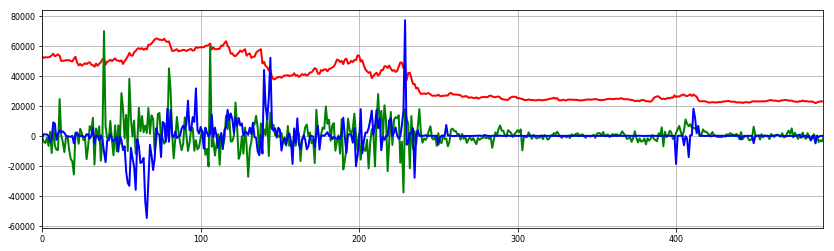

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['lines.linewidth'] = 2
plt.rcParams["font.family"] = 'nanummyeongjo'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.size"] = 8
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['axes.grid'] = True


krx1['종가'].plot(color='r')
krx1['외국인_순매수(주)'].plot(color='g')
krx1['기관_순매수(주)'].plot(color='b')


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


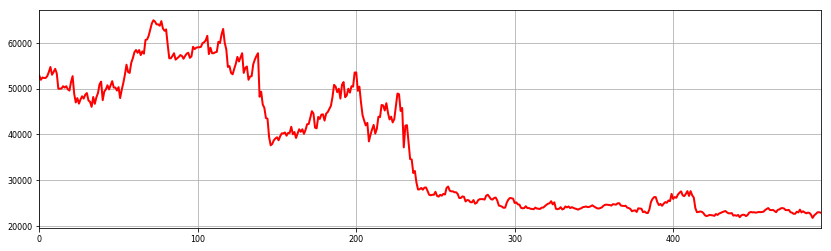

In [61]:
krx1['종가'].plot(color='r')

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


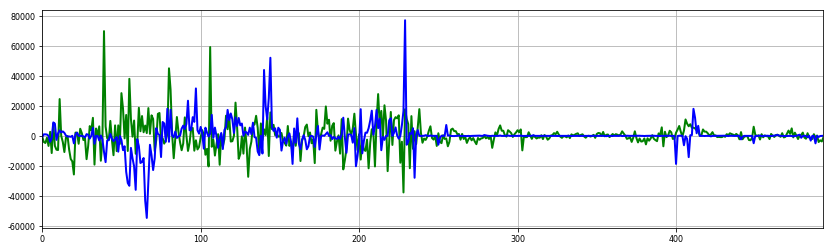

In [62]:
krx1['외국인_순매수(주)'].plot(color='g')
krx1['기관_순매수(주)'].plot(color='b')

IndexError: index 3 is out of bounds for axis 1 with size 3

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


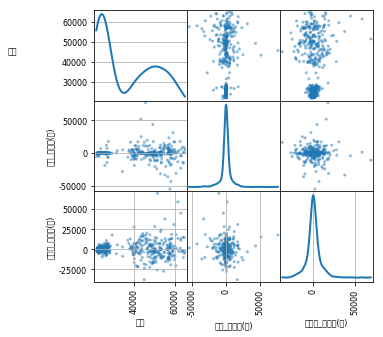

In [63]:
import numpy as np
from pandas_datareader import data
from pandas.plotting import scatter_matrix
import scipy as sp

krx1 = krx1[['년/월/일', '종가', '기관_순매수(주)', '외국인_순매수(주)']]

axs = scatter_matrix(krx1, diagonal='kde', figsize=(5, 5))
n = len(krx1.columns)

for x in range(n):
    for y in range(n):
        ax = axs[x, y]
        ax.xaxis.label.set_rotation(90)
        ax.yaxis.label.set_rotation(0)
        ax.yaxis.labelpad = 50
        
plt.show()

## Case2 : 하나금융지주(KR7086790003)

In [15]:
krx1 = stock_foreign_krx('KR7086790003')
krx1 = krx1[:-1]      #마지막 합계 제거
krx1.head(10)

,년/월/일,종가,대비,거래량(주),기관_매수량(주),기관_매도량(주),기관_순매수(주),외국인_매수량(주),외국인_매도량(주),외국인_순매수(주)
0,2017/08/31,49000.0,-600.0,1084470,74445,209835,-135390,848872,732899,115973
1,2017/08/30,49600.0,-600.0,753448,115420,102486,12934,503316,567398,-64082
2,2017/08/29,50200.0,100.0,626883,136947,196420,-59473,415912,311332,104580
3,2017/08/28,50100.0,-400.0,487351,116994,103046,13948,320564,330320,-9756
4,2017/08/25,50500.0,1850.0,666463,180129,215264,-35135,424531,236462,188069
5,2017/08/24,48650.0,-600.0,547493,111265,253897,-142632,311270,236563,74707
6,2017/08/23,49250.0,50.0,737120,163222,129127,34095,485688,466559,19129
7,2017/08/22,49200.0,-450.0,670227,120172,206214,-86042,403774,368089,35685
8,2017/08/21,49650.0,-350.0,354826,48843,66132,-17289,232236,206099,26137
9,2017/08/18,50000.0,-200.0,567058,79396,114740,-35344,417419,300319,117100


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


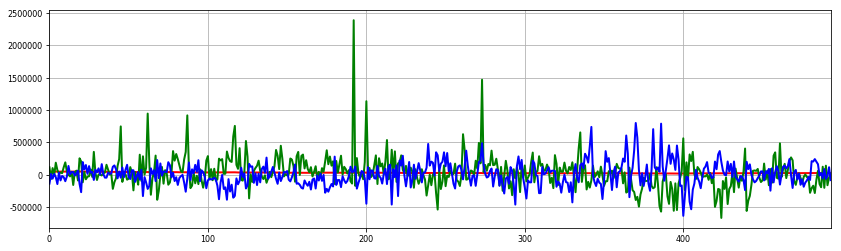

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['lines.linewidth'] = 2
plt.rcParams["font.family"] = 'nanummyeongjo'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.size"] = 8
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['axes.grid'] = True


krx1['종가'].plot(color='r')
krx1['외국인_순매수(주)'].plot(color='g')
krx1['기관_순매수(주)'].plot(color='b')


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


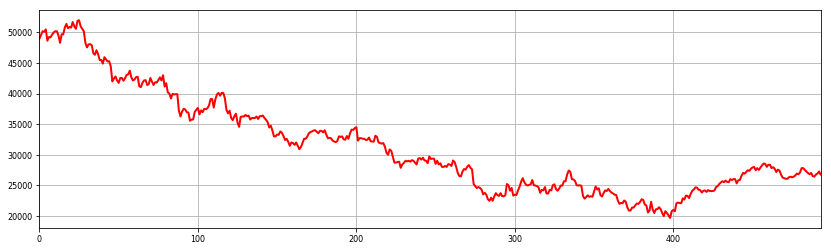

In [17]:
krx1['종가'].plot(color='r')

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


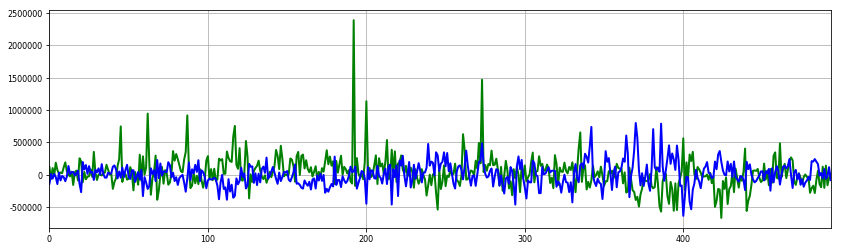

In [18]:
krx1['외국인_순매수(주)'].plot(color='g')
krx1['기관_순매수(주)'].plot(color='b')

IndexError: index 3 is out of bounds for axis 1 with size 3

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


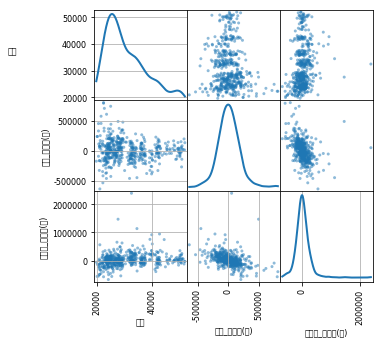

In [19]:
import numpy as np
from pandas_datareader import data
from pandas.plotting import scatter_matrix
import scipy as sp

krx1 = krx1[['년/월/일', '종가', '기관_순매수(주)', '외국인_순매수(주)']]

axs = scatter_matrix(krx1, diagonal='kde', figsize=(5, 5))
n = len(krx1.columns)

for x in range(n):
    for y in range(n):
        ax = axs[x, y]
        ax.xaxis.label.set_rotation(90)
        ax.yaxis.label.set_rotation(0)
        ax.yaxis.labelpad = 50
        
plt.show()

## Case3 : DGB금융지주

In [90]:
#필요한 colunm만 뽑아내기
krx1 = stock_foreign_krx(code_to_isin('139130'))
#krx1 = krx1[['년/월/일', '종가', '기관_순매수(주)', '외국인_순매수(주)']]

#마지막 합계 제거
krx1 = krx1[:-1]

krx1.head(10)

,년/월/일,종가,대비,거래량(주),기관_매수량(주),기관_매도량(주),기관_순매수(주),외국인_매수량(주),외국인_매도량(주),외국인_순매수(주)
0,2017/08/31,11000.0,-200.0,707432,88473,139850,-51377,400488,475457,-74969
1,2017/08/30,11200.0,-250.0,499357,96672,128218,-31546,257519,305272,-47753
2,2017/08/29,11450.0,0.0,338609,152682,4791,147891,81951,238159,-156208
3,2017/08/28,11450.0,200.0,415727,124610,43315,81295,146104,117715,28389
4,2017/08/25,11250.0,350.0,547107,60532,176374,-115842,453408,73293,380115
5,2017/08/24,10900.0,-300.0,822145,65243,252425,-187182,297127,381354,-84227
6,2017/08/23,11200.0,-100.0,397522,90328,73906,16422,201120,240347,-39227
7,2017/08/22,11300.0,-50.0,266651,32469,77873,-45404,122582,140163,-17581
8,2017/08/21,11350.0,-100.0,408099,106239,120661,-14422,121068,163406,-42338
9,2017/08/18,11450.0,-50.0,262161,31284,57654,-26370,131969,109372,22597


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


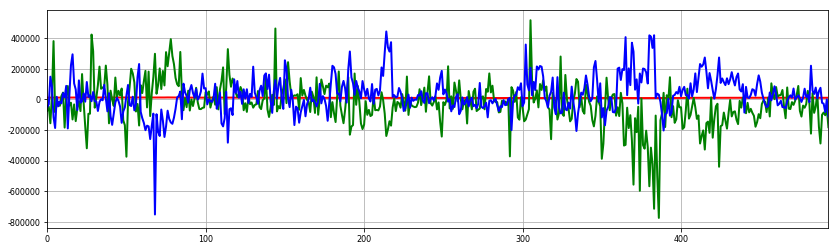

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['lines.linewidth'] = 2
plt.rcParams["font.family"] = 'nanummyeongjo'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.size"] = 8
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['axes.grid'] = True


krx1['종가'].plot(color='r')
krx1['외국인_순매수(주)'].plot(color='g')
krx1['기관_순매수(주)'].plot(color='b')


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


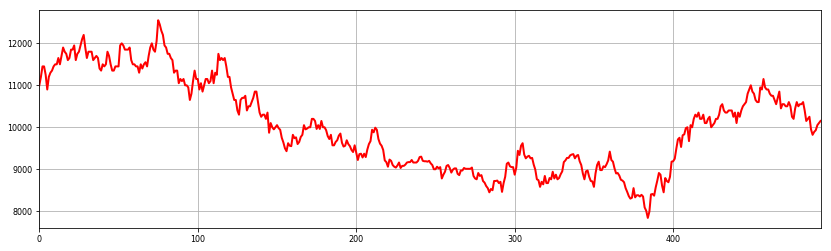

In [92]:
krx1['종가'].plot(color='r')

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


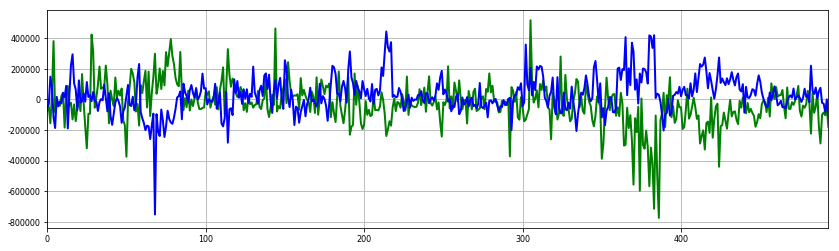

In [93]:
krx1['외국인_순매수(주)'].plot(color='g')
krx1['기관_순매수(주)'].plot(color='b')

IndexError: index 3 is out of bounds for axis 1 with size 3

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


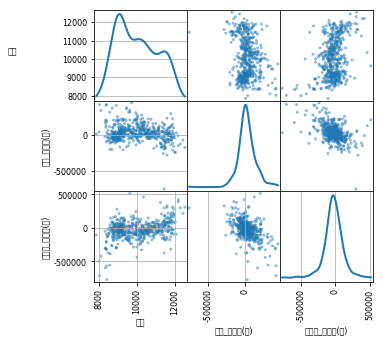

In [94]:
import numpy as np
from pandas_datareader import data
from pandas.plotting import scatter_matrix
import scipy as sp

krx1 = krx1[['년/월/일', '종가', '기관_순매수(주)', '외국인_순매수(주)']]

axs = scatter_matrix(krx1, diagonal='kde', figsize=(5, 5))
n = len(krx1.columns)

for x in range(n):
    for y in range(n):
        ax = axs[x, y]
        ax.xaxis.label.set_rotation(90)
        ax.yaxis.label.set_rotation(0)
        ax.yaxis.labelpad = 50
        
plt.show()

## Case4 : 아모레퍼시픽(KR7002790004)

In [84]:
#필요한 colunm만 뽑아내기
krx1 = stock_foreign_krx(code_to_isin('002790'))
#krx1 = krx1[['년/월/일', '종가', '기관_순매수(주)', '외국인_순매수(주)']]

#마지막 합계 제거
krx1 = krx1[:-1]

krx1.head(10)

,년/월/일,종가,대비,거래량(주),기관_매수량(주),기관_매도량(주),기관_순매수(주),외국인_매수량(주),외국인_매도량(주),외국인_순매수(주)
0,2017/08/31,134000.0,-1500.0,43044,5787,7430,-1643,29027,24699,4328
1,2017/08/30,135500.0,-500.0,83979,7346,34559,-27213,69707,37438,32269
2,2017/08/29,136000.0,500.0,100095,19250,19538,-288,71872,58271,13601
3,2017/08/28,135500.0,1500.0,77652,17789,24505,-6716,49236,38852,10384
4,2017/08/25,134000.0,0.0,172009,11629,67589,-55960,143749,79733,64016
5,2017/08/24,134000.0,6000.0,198194,79196,67754,11442,84815,51244,33571
6,2017/08/23,128000.0,500.0,67810,15886,15824,62,46341,38163,8178
7,2017/08/22,127500.0,2500.0,75192,20359,16554,3805,50025,36565,13460
8,2017/08/21,125000.0,-500.0,73392,2806,13234,-10428,66311,47716,18595
9,2017/08/18,125500.0,-500.0,90890,14293,29296,-15003,64618,26368,38250


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


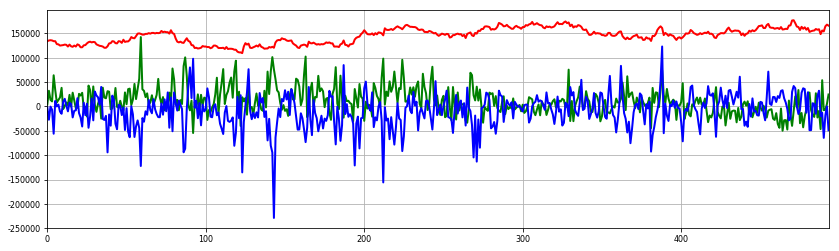

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams['lines.linewidth'] = 2
plt.rcParams["font.family"] = 'nanummyeongjo'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.size"] = 8
plt.rcParams["figure.figsize"] = (14,4)
plt.rcParams['axes.grid'] = True


krx1['종가'].plot(color='r')
krx1['외국인_순매수(주)'].plot(color='g')
krx1['기관_순매수(주)'].plot(color='b')


/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


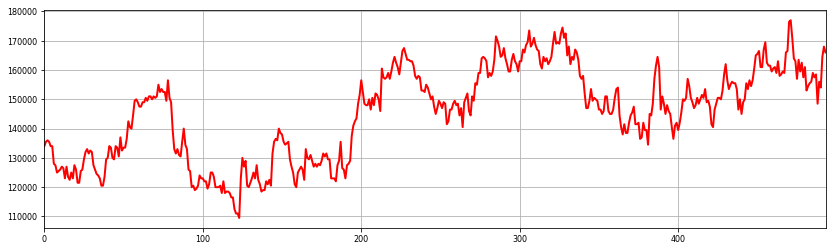

In [86]:
krx1['종가'].plot(color='r')

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


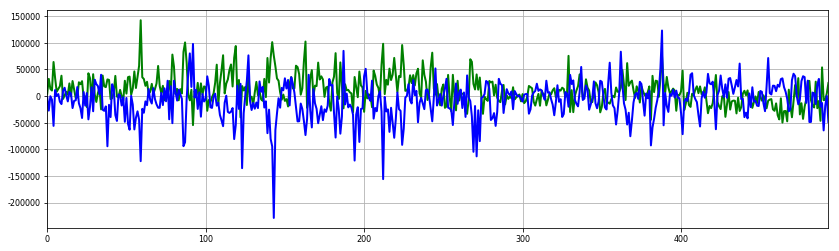

In [87]:
krx1['외국인_순매수(주)'].plot(color='g')
krx1['기관_순매수(주)'].plot(color='b')

IndexError: index 3 is out of bounds for axis 1 with size 3

/usr/local/lib/python3.4/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['nanummyeongjo'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


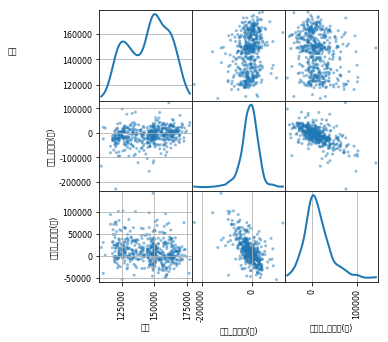

In [88]:
import numpy as np
from pandas_datareader import data
from pandas.plotting import scatter_matrix
import scipy as sp

krx1 = krx1[['년/월/일', '종가', '기관_순매수(주)', '외국인_순매수(주)']]

axs = scatter_matrix(krx1, diagonal='kde', figsize=(5, 5))
n = len(krx1.columns)

for x in range(n):
    for y in range(n):
        ax = axs[x, y]
        ax.xaxis.label.set_rotation(90)
        ax.yaxis.label.set_rotation(0)
        ax.yaxis.labelpad = 50
        
plt.show()

/bin/sh: 1: /home/ubuntu/workspace/: Permission denied


In [82]:
#자료 저장(CSV)
krx1 = stock_foreign_krx(code_to_isin('003230'))
krx1.to_csv('003230.csv', encoding="euc-kr" )


# 7.소결 : 추론통계 관점

1. 10번 반복한 결과, 위와 같은 Index가 구상됨
2. Index 내용을 기준으로, 반복하면 1시간 소요됨
3. 결론은... 의미없는 상황임
4. 이러한 까닭에 실무에서는 추론통계가 안쓰임
5. 다만, 역량개발을 위해서는 1년에 1번정도는 필요함
   (1년에 통계학책 1번 읽으라는 말하고 크게 다름)